In [1]:
import tensorflow as tf 
from tensorflow import keras

from matplotlib import pyplot as plt
from matplotlib import ticker

import unicodedata
import re
import numpy as np
import time

from pathlib import Path 

from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, "..")

print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

2.2.0
1 Physical GPUs, 1 Logical GPUs


In [2]:
## Download file
data_path = Path("..") / "datasets" / "data"

In [3]:
path_to_zip = tf.keras.utils.get_file(data_path.resolve() / "spa-eng.zip", origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip", extract=True)
spa_eng_file_path = data_path / "spa-eng" / "spa.txt"

In [4]:
## Helpful functions

def unicode_to_ascii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    ## Create space between a word and the punctuation following the word
    ## https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    ## replace everything with space except common alphabets and few symbols
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.strip()
    
    ## add start and end tokens
    w = "<start> " + w + " <end>"
    
    return w

In [5]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [6]:
def create_dataset(path, num_examples):
    with open(path, "r", encoding='UTF-8') as o:
        lines = o.read().strip().split("\n")
        word_pairs = [[preprocess_sentence(w) for w in line.split('\t')] for line in lines[:num_examples]]
    return zip(*word_pairs)

In [7]:
en, sp = create_dataset(spa_eng_file_path, None)

In [8]:
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [9]:
def tokenize(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        filters="")
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples):
    targ_lang, inp_lang = create_dataset(path, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [11]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(spa_eng_file_path, num_examples=num_examples)

In [12]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [13]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [14]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print(f"{t} ----> {lang.index_word[t]}")

In [15]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
1088 ----> muestrame
45 ----> como
164 ----> hacerlo
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
255 ----> show
17 ----> me
52 ----> how
15 ----> to
22 ----> do
10 ----> it
3 ----> .
2 ----> <end>


## Create tf.data Dataset

In [16]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## Create the Encode and Decoder

In [19]:
from nmt.networks import Encoder, Decoder
from nmt.models import NMTModel

In [20]:
optimizer = keras.optimizers.Adam()
loss_objective = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_objective(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [21]:
encoder = Encoder(vocab_inp_size, embedding_dim, units)
decoder = Decoder(vocab_tar_size, embedding_dim, units)

In [22]:
sample_hidden = encoder.initialize_hidden_state(BATCH_SIZE)
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [23]:
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## Define the NMT Model and Fit

In [24]:
nmt_model = NMTModel(encoder, decoder, targ_lang)

In [25]:
nmt_model.compile(optimizer, loss_function)

In [26]:
nmt_model.fit(dataset, epochs=10)

Epoch 1/10
375/375 [==============================] - 21s 57ms/step - loss: 23.5074
Epoch 2/10
375/375 [==============================] - 21s 57ms/step - loss: 17.5941
Epoch 3/10
375/375 [==============================] - 21s 57ms/step - loss: 15.2719
Epoch 4/10
375/375 [==============================] - 21s 57ms/step - loss: 12.4311
Epoch 5/10
375/375 [==============================] - 21s 57ms/step - loss: 9.3730
Epoch 6/10
375/375 [==============================] - 21s 57ms/step - loss: 6.8214
Epoch 7/10
375/375 [==============================] - 21s 57ms/step - loss: 4.9287
Epoch 8/10
375/375 [==============================] - 21s 57ms/step - loss: 3.6149
Epoch 9/10
375/375 [==============================] - 21s 57ms/step - loss: 2.7171
Epoch 10/10
375/375 [==============================] - 21s 57ms/step - loss: 2.1132


## Evaluate

In [27]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [28]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [29]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


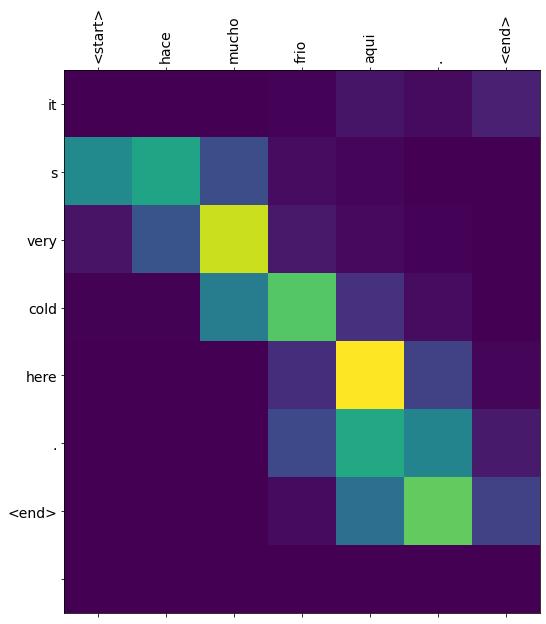

In [30]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


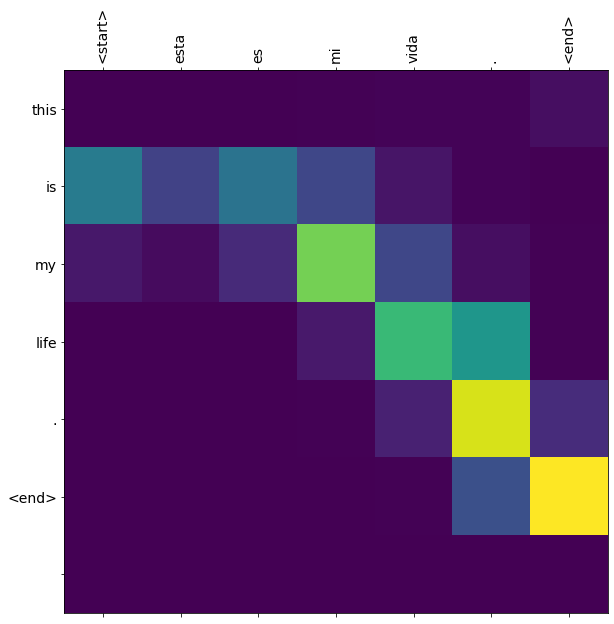

In [31]:
translate(u'esta es mi vida.')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to be done . <end> 


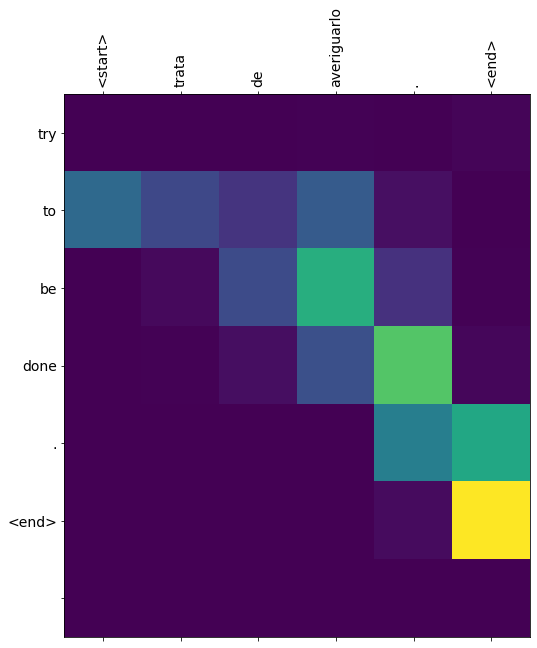

In [33]:
translate(u'trata de averiguarlo.')